In [136]:
!pip3 install --quiet matplotlib numpy pandas scikit-learn seaborn plotly

# Data Cleaning

In [137]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import warnings

In [138]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

# Data loading and preprocessing functions
def load_all_data():
    """Load all raw and processed data files"""
    data = {}
    
    # Load raw data
    data['acorn_details'] = pd.read_csv('data/00_raw/acorn_details.csv', encoding='ISO-8859-1')
    data['temperatures'] = pd.read_csv('data/00_raw/temperatures.csv', sep=';', decimal=',', encoding='utf-8')
    data['uk_bank_holidays'] = pd.read_csv('data/00_raw/uk_bank_holidays.csv')
    data['weather_daily'] = pd.read_csv('data/00_raw/weather_daily_darksky.csv')
    data['weather_hourly'] = pd.read_csv('data/00_raw/weather_hourly_darksky.csv')
    
    # Load processed data from parquet
    data['group_4_daily_predict'] = pd.read_parquet('data/02_processed/parquet/group_4_daily_predict.parquet')
    data['group_4_half_hourly_predict'] = pd.read_parquet('data/02_processed/parquet/group_4_half_hourly_predict.parquet')
    data['group_4_daily'] = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')
    data['group_4_half_hourly'] = pd.read_parquet('data/02_processed/parquet/group_4_half_hourly.parquet')
    
    return data

def fix_datetime_formats(data):
    """Fix datetime formats for all datasets"""
    # Fix temperatures datetime
    data['temperatures']['DateTime'] = pd.to_datetime(data['temperatures']['DateTime'], format='mixed')
    
    # Fix bank holidays datetime
    data['uk_bank_holidays']['Bank holidays'] = pd.to_datetime(data['uk_bank_holidays']['Bank holidays'], format='mixed')
    
    # Fix weather daily datetime columns
    datetime_columns = ['temperatureMaxTime', 'temperatureMinTime', 'apparentTemperatureMinTime', 
                       'apparentTemperatureHighTime', 'time', 'sunsetTime', 'sunriseTime', 
                       'temperatureHighTime', 'uvIndexTime', 'temperatureLowTime', 
                       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime']
    
    for col in datetime_columns:
        data['weather_daily'][col] = pd.to_datetime(data['weather_daily'][col])
    
    return data

# Seasonal analysis functions
def get_season(month):
    """Convert month number to season name"""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # months 9, 10, 11
        return 'Fall'

def add_temporal_features(df, datetime_col='DateTime'):
    """Add temporal features to dataframe"""
    df = df.copy()
    df['Hour'] = df[datetime_col].dt.hour
    df['Day'] = df[datetime_col].dt.day_name()
    df['Date'] = df[datetime_col].dt.date
    df['Season'] = df[datetime_col].dt.month.apply(get_season)
    return df

# Plotting utility functions
def create_boxplot_by_acorn(data, y_col='Conso_moy', title_prefix='', figsize=(12, 6)):
    """Create boxplot comparing Acorn groups"""
    plt.figure(figsize=figsize)
    sns.boxplot(x='Acorn', y=y_col, data=data, palette='Set2')
    plt.title(f'{title_prefix} Consumption by Acorn Group')
    plt.xlabel('Acorn Group')
    plt.ylabel('Consumption (kWh)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def create_heatmap_by_acorn(data, acorn_groups, day_order, figsize=(20, 6)):
    """Create heatmaps for each Acorn group showing hour vs day patterns"""
    fig, axes = plt.subplots(1, len(acorn_groups), figsize=figsize)
    
    # Calculate global min and max for consistent color scale
    all_means = []
    for acorn in acorn_groups:
        acorn_data = data[data['Acorn'] == acorn]
        heatmap_data = acorn_data.pivot_table(index='Hour', columns='Day', values='Conso_moy', aggfunc='mean')
        all_means.extend(heatmap_data.values.flatten())
    
    # Remove NaN values and calculate global range
    all_means = [x for x in all_means if not pd.isna(x)]
    vmin, vmax = min(all_means), max(all_means)
    
    for idx, acorn in enumerate(acorn_groups):
        # Filter data for current Acorn group
        acorn_data = data[data['Acorn'] == acorn]
        
        # Create pivot table for heatmap
        heatmap_data = acorn_data.pivot_table(index='Hour', columns='Day', values='Conso_moy', aggfunc='mean')
        heatmap_data = heatmap_data.reindex(columns=day_order)
        
        # Create heatmap with consistent color scale
        sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.2f', 
                    cbar_kws={'label': 'Average Consumption (kWh)'}, ax=axes[idx],
                    vmin=vmin, vmax=vmax)
        axes[idx].set_title(f'Consumption Heatmap - {acorn}')
        axes[idx].set_xlabel('Day of the Week')
        axes[idx].set_ylabel('Hour of the Day')
    
    plt.tight_layout()
    plt.show()

def create_load_duration_curves(data, acorn_groups, figsize=(18, 6)):
    """Create load duration curves for each Acorn group"""
    fig, axes = plt.subplots(1, len(acorn_groups), figsize=figsize)
    
    for idx, acorn_group in enumerate(acorn_groups):
        # Filter data for current Acorn group
        acorn_data = data[data['Acorn'] == acorn_group]
        
        # Sort consumption values in descending order
        sorted_consumption = acorn_data['Conso_moy'].sort_values(ascending=False).reset_index(drop=True)
        
        # Create time duration as percentage (0 to 100%)
        duration_percent = (sorted_consumption.index / len(sorted_consumption)) * 100
        
        # Plot load duration curve
        axes[idx].plot(duration_percent, sorted_consumption, linewidth=2, color='blue')
        axes[idx].set_title(f'Load Duration Curve - {acorn_group}')
        axes[idx].set_xlabel('Duration (%)')
        axes[idx].set_ylabel('Consumption (kWh)')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xlim(0, 100)
    
    plt.tight_layout()
    plt.show()

def create_temporal_boxplots(data, acorn_groups, day_order, figsize=(20, 12)):
    """Create boxplots showing temporal patterns for each Acorn group"""
    fig, axes = plt.subplots(2, len(acorn_groups), figsize=figsize)
    
    for idx, acorn_group in enumerate(acorn_groups):
        acorn_data = data[data['Acorn'] == acorn_group]
        
        # Hour boxplot
        sns.boxplot(x='Hour', y='Conso_moy', data=acorn_data, ax=axes[0, idx], 
                   hue='Hour', palette='viridis', legend=False)
        axes[0, idx].set_title(f'Consumption by Hour - {acorn_group}')
        axes[0, idx].set_xlabel('Hour of Day')
        axes[0, idx].set_ylabel('Consumption (kWh)')
        axes[0, idx].tick_params(axis='x', rotation=45)
        
        # Day of week boxplot
        sns.boxplot(x='Day', y='Conso_moy', data=acorn_data, ax=axes[1, idx], 
                   order=day_order, hue='Day', palette='Set2', legend=False)
        axes[1, idx].set_title(f'Consumption by Day - {acorn_group}')
        axes[1, idx].set_xlabel('Day of Week')
        axes[1, idx].set_ylabel('Consumption (kWh)')
        axes[1, idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def create_seasonal_analysis(data, acorn_groups, season_order, figsize=(16, 20)):
    """Create seasonal subseries analysis plots"""
    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
    
    for idx, season in enumerate(season_order):
        season_data = data[data['Season'] == season]
        
        for acorn_group in acorn_groups:
            acorn_season_data = season_data[season_data['Acorn'] == acorn_group]
            
            if len(acorn_season_data) > 0:
                # Calculate hourly means for this season and Acorn group
                hourly_means = acorn_season_data.groupby('Hour')['Conso_moy'].mean()
                hourly_std = acorn_season_data.groupby('Hour')['Conso_moy'].std()
                
                # Plot the hourly pattern
                axes[idx].plot(hourly_means.index, hourly_means.values, 
                              marker='o', linewidth=2, markersize=4, 
                              label=acorn_group, alpha=0.8)
                
                # Add confidence intervals
                axes[idx].fill_between(hourly_means.index,
                                      hourly_means.values - hourly_std.values,
                                      hourly_means.values + hourly_std.values,
                                      alpha=0.2)
        
        # Customize each subplot
        axes[idx].set_title(f'{season} - Hourly Consumption Patterns', 
                           fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Average Consumption (kWh)', fontsize=12)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(title='Acorn Group', loc='upper right')
        axes[idx].set_xticks(range(0, 24, 2))
        axes[idx].set_xlim(0, 23)
    
    axes[3].set_xlabel('Hour of Day', fontsize=12)
    plt.suptitle('Seasonal Subseries: Hourly Consumption Patterns by Season', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

def print_seasonal_summary(data, acorn_groups, season_order):
    """Print seasonal summary statistics"""
    print("\n=== SEASONAL SUBSERIES ANALYSIS ===")
    print("Peak hours and consumption levels by season and Acorn group:")
    
    for season in season_order:
        print(f"\n--- {season.upper()} ---")
        season_data = data[data['Season'] == season]
        
        for acorn_group in acorn_groups:
            acorn_season_data = season_data[season_data['Acorn'] == acorn_group]
            
            if len(acorn_season_data) > 0:
                hourly_means = acorn_season_data.groupby('Hour')['Conso_moy'].mean()
                
                # Find peak and minimum hours
                peak_hour = hourly_means.idxmax()
                min_hour = hourly_means.idxmin()
                peak_consumption = hourly_means.max()
                min_consumption = hourly_means.min()
                
                print(f"{acorn_group}: Peak at {peak_hour:02d}:00 ({peak_consumption:.3f} kWh), "
                      f"Min at {min_hour:02d}:00 ({min_consumption:.3f} kWh)")

# Function to perform statistical tests
def perform_holiday_statistical_analysis(data, acorn_groups, consumption_col='Conso_kWh'):
    """Perform statistical tests comparing holidays vs weekends and holidays vs weekdays"""
    from scipy import stats
    
    results = []
    
    for acorn_group in acorn_groups:
        acorn_data = data[data['Acorn'] == acorn_group]
        
        holiday_consumption = acorn_data[acorn_data['Day_Category'] == 'Holiday'][consumption_col]
        weekend_consumption = acorn_data[acorn_data['Day_Category'] == 'Weekend'][consumption_col]
        weekday_consumption = acorn_data[acorn_data['Day_Category'] == 'Weekday'][consumption_col]
        
        # Holiday vs Weekend
        if len(holiday_consumption) > 0 and len(weekend_consumption) > 0:
            t_stat_hw, p_value_hw = stats.ttest_ind(holiday_consumption, weekend_consumption)
            pooled_std_hw = np.sqrt(((len(holiday_consumption) - 1) * holiday_consumption.var() + 
                                     (len(weekend_consumption) - 1) * weekend_consumption.var()) / 
                                    (len(holiday_consumption) + len(weekend_consumption) - 2))
            cohens_d_hw = (holiday_consumption.mean() - weekend_consumption.mean()) / pooled_std_hw if pooled_std_hw else 0
            
            results.append({
                'Comparison': 'Holiday vs Weekend',
                'Acorn_Group': acorn_group,
                'Group1_Mean': holiday_consumption.mean(),
                'Group1_Std': holiday_consumption.std(),
                'Group1_Count': len(holiday_consumption),
                'Group2_Mean': weekend_consumption.mean(),
                'Group2_Std': weekend_consumption.std(),
                'Group2_Count': len(weekend_consumption),
                'Mean_Difference': holiday_consumption.mean() - weekend_consumption.mean(),
                'T_Statistic': t_stat_hw,
                'P_Value': p_value_hw,
                'Cohens_D': cohens_d_hw,
                'Significant': p_value_hw < 0.05
            })

        # Holiday vs Weekday
        if len(holiday_consumption) > 0 and len(weekday_consumption) > 0:
            t_stat_hd, p_value_hd = stats.ttest_ind(holiday_consumption, weekday_consumption)
            pooled_std_hd = np.sqrt(((len(holiday_consumption) - 1) * holiday_consumption.var() + 
                                     (len(weekday_consumption) - 1) * weekday_consumption.var()) / 
                                    (len(holiday_consumption) + len(weekday_consumption) - 2))
            cohens_d_hd = (holiday_consumption.mean() - weekday_consumption.mean()) / pooled_std_hd if pooled_std_hd else 0
            
            results.append({
                'Comparison': 'Holiday vs Weekday',
                'Acorn_Group': acorn_group,
                'Group1_Mean': holiday_consumption.mean(),
                'Group1_Std': holiday_consumption.std(),
                'Group1_Count': len(holiday_consumption),
                'Group2_Mean': weekday_consumption.mean(),
                'Group2_Std': weekday_consumption.std(),
                'Group2_Count': len(weekday_consumption),
                'Mean_Difference': holiday_consumption.mean() - weekday_consumption.mean(),
                'T_Statistic': t_stat_hd,
                'P_Value': p_value_hd,
                'Cohens_D': cohens_d_hd,
                'Significant': p_value_hd < 0.05
            })
            
    return pd.DataFrame(results)

############################################################################################################

# Global constants
DAY_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
SEASON_ORDER = ['Winter', 'Spring', 'Summer', 'Fall']

In [139]:
# Changing the path to the root of the repository

if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

In [140]:
# Load all data using utility function
data = load_all_data()

# Extract individual datasets for backward compatibility
acorn_details = data['acorn_details']
temperatures = data['temperatures']
uk_bank_holidays = data['uk_bank_holidays']
weather_daily = data['weather_daily']
weather_hourly = data['weather_hourly']
group_4_daily_predict = data['group_4_daily_predict']
group_4_half_hourly_predict = data['group_4_half_hourly_predict']
group_4_daily = data['group_4_daily']
group_4_half_hourly = data['group_4_half_hourly']

In [141]:
# Fix datetime formats using utility function
data = fix_datetime_formats(data)

# Update individual variables
temperatures = data['temperatures']
uk_bank_holidays = data['uk_bank_holidays']
weather_daily = data['weather_daily']

# Conso by Acorn - Hourly

## Different Granularities

/var/folders/yx/m9tgkp2d2yqd4by19_p5l1gm0000gn/T/ipykernel_24574/1322828857.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Acorn', y=y_col, data=data, palette='Set2')


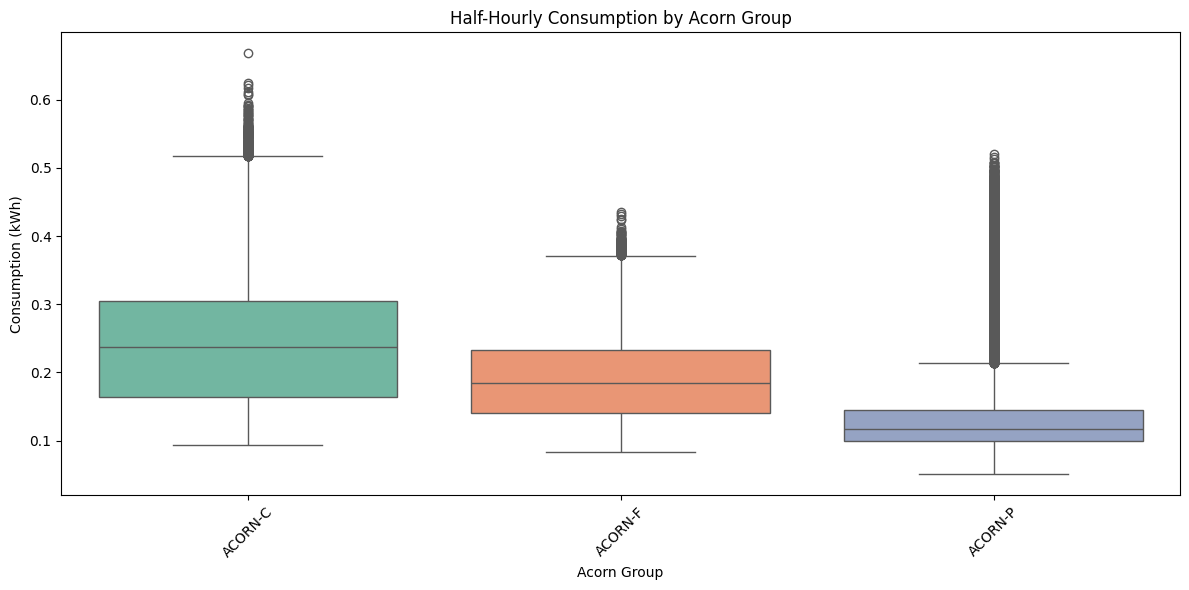

In [142]:
# Conso by Acorn group (half-hourly)
# Copying
group_4_half_hourly = group_4_half_hourly.copy()
group_4_half_hourly['Acorn'] = group_4_half_hourly['Acorn'].astype('category')

# Prepare data with temporal features
group_4_half_hourly = add_temporal_features(group_4_half_hourly)

# Create boxplot using utility function
create_boxplot_by_acorn(group_4_half_hourly, title_prefix='Half-Hourly')

# Get Acorn groups for later use
acorn_groups = group_4_half_hourly['Acorn'].unique()

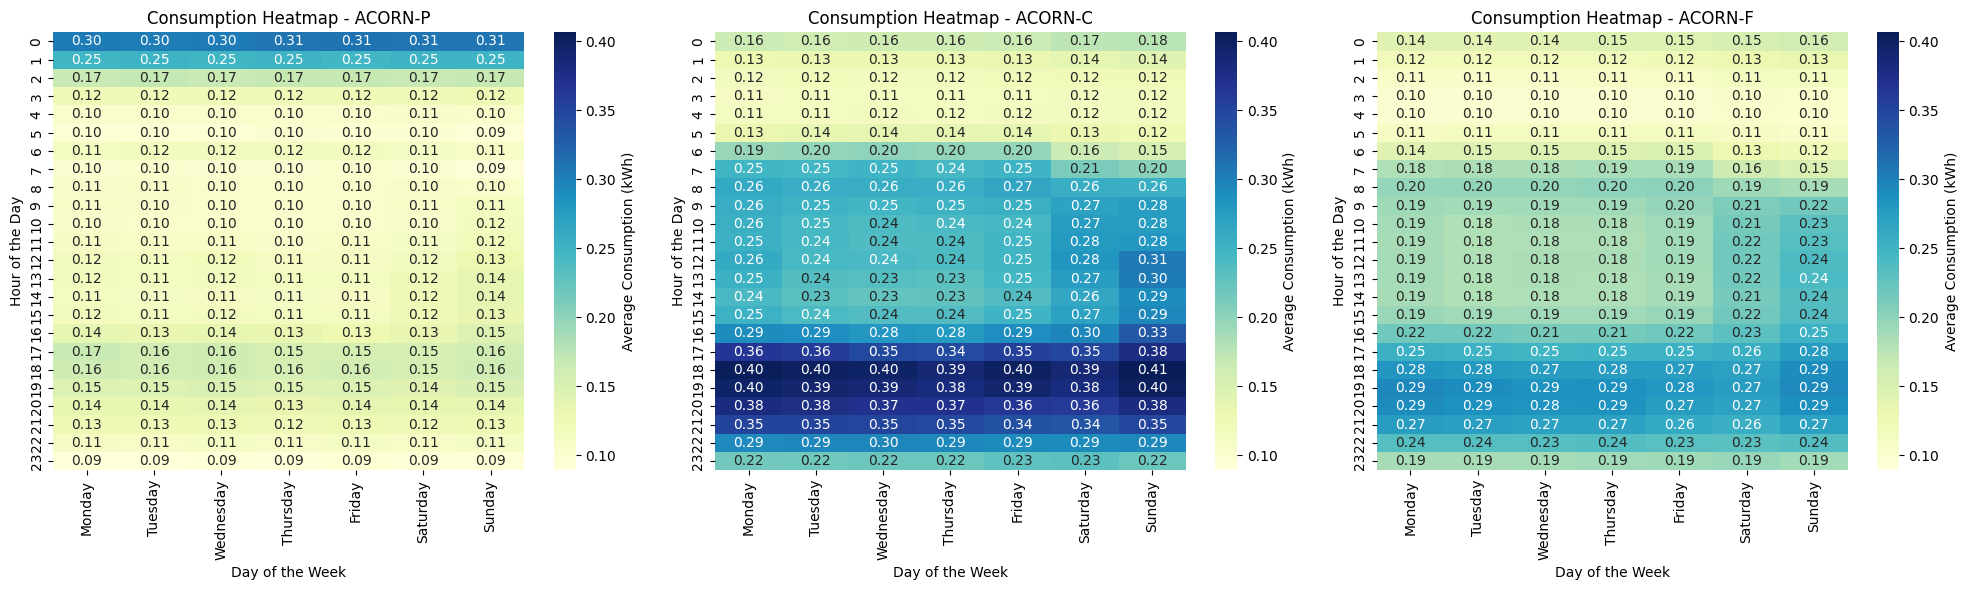

In [143]:
# Create separate heatmaps for each Acorn group
acorn_groups = group_4_half_hourly['Acorn'].unique()

# Define the correct order for days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Extract hour and day from DateTime
group_4_half_hourly['Hour'] = group_4_half_hourly['DateTime'].dt.hour
group_4_half_hourly['Day'] = group_4_half_hourly['DateTime'].dt.day_name()

# Create heatmaps using utility function
create_heatmap_by_acorn(group_4_half_hourly, acorn_groups, day_order)

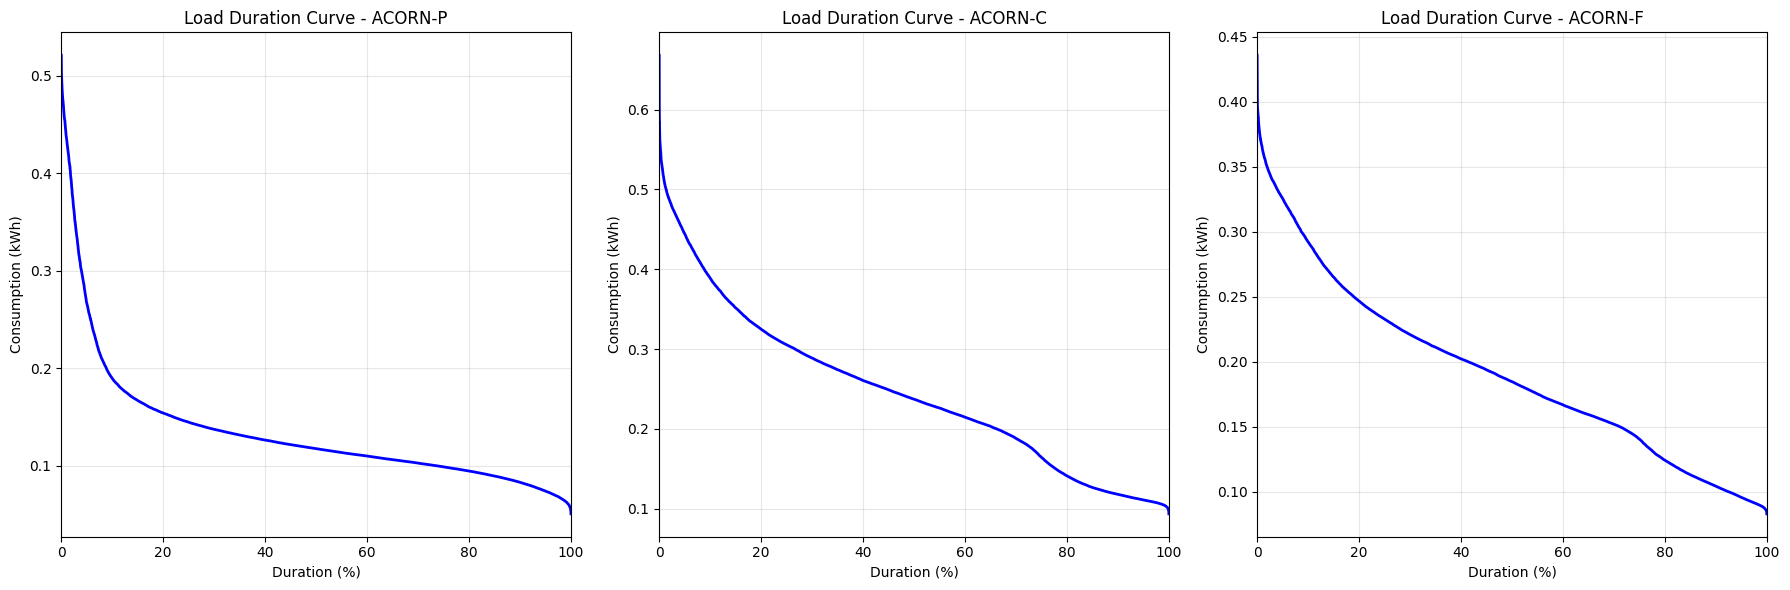

In [144]:
# Load Duration Curves
create_load_duration_curves(group_4_half_hourly, acorn_groups)

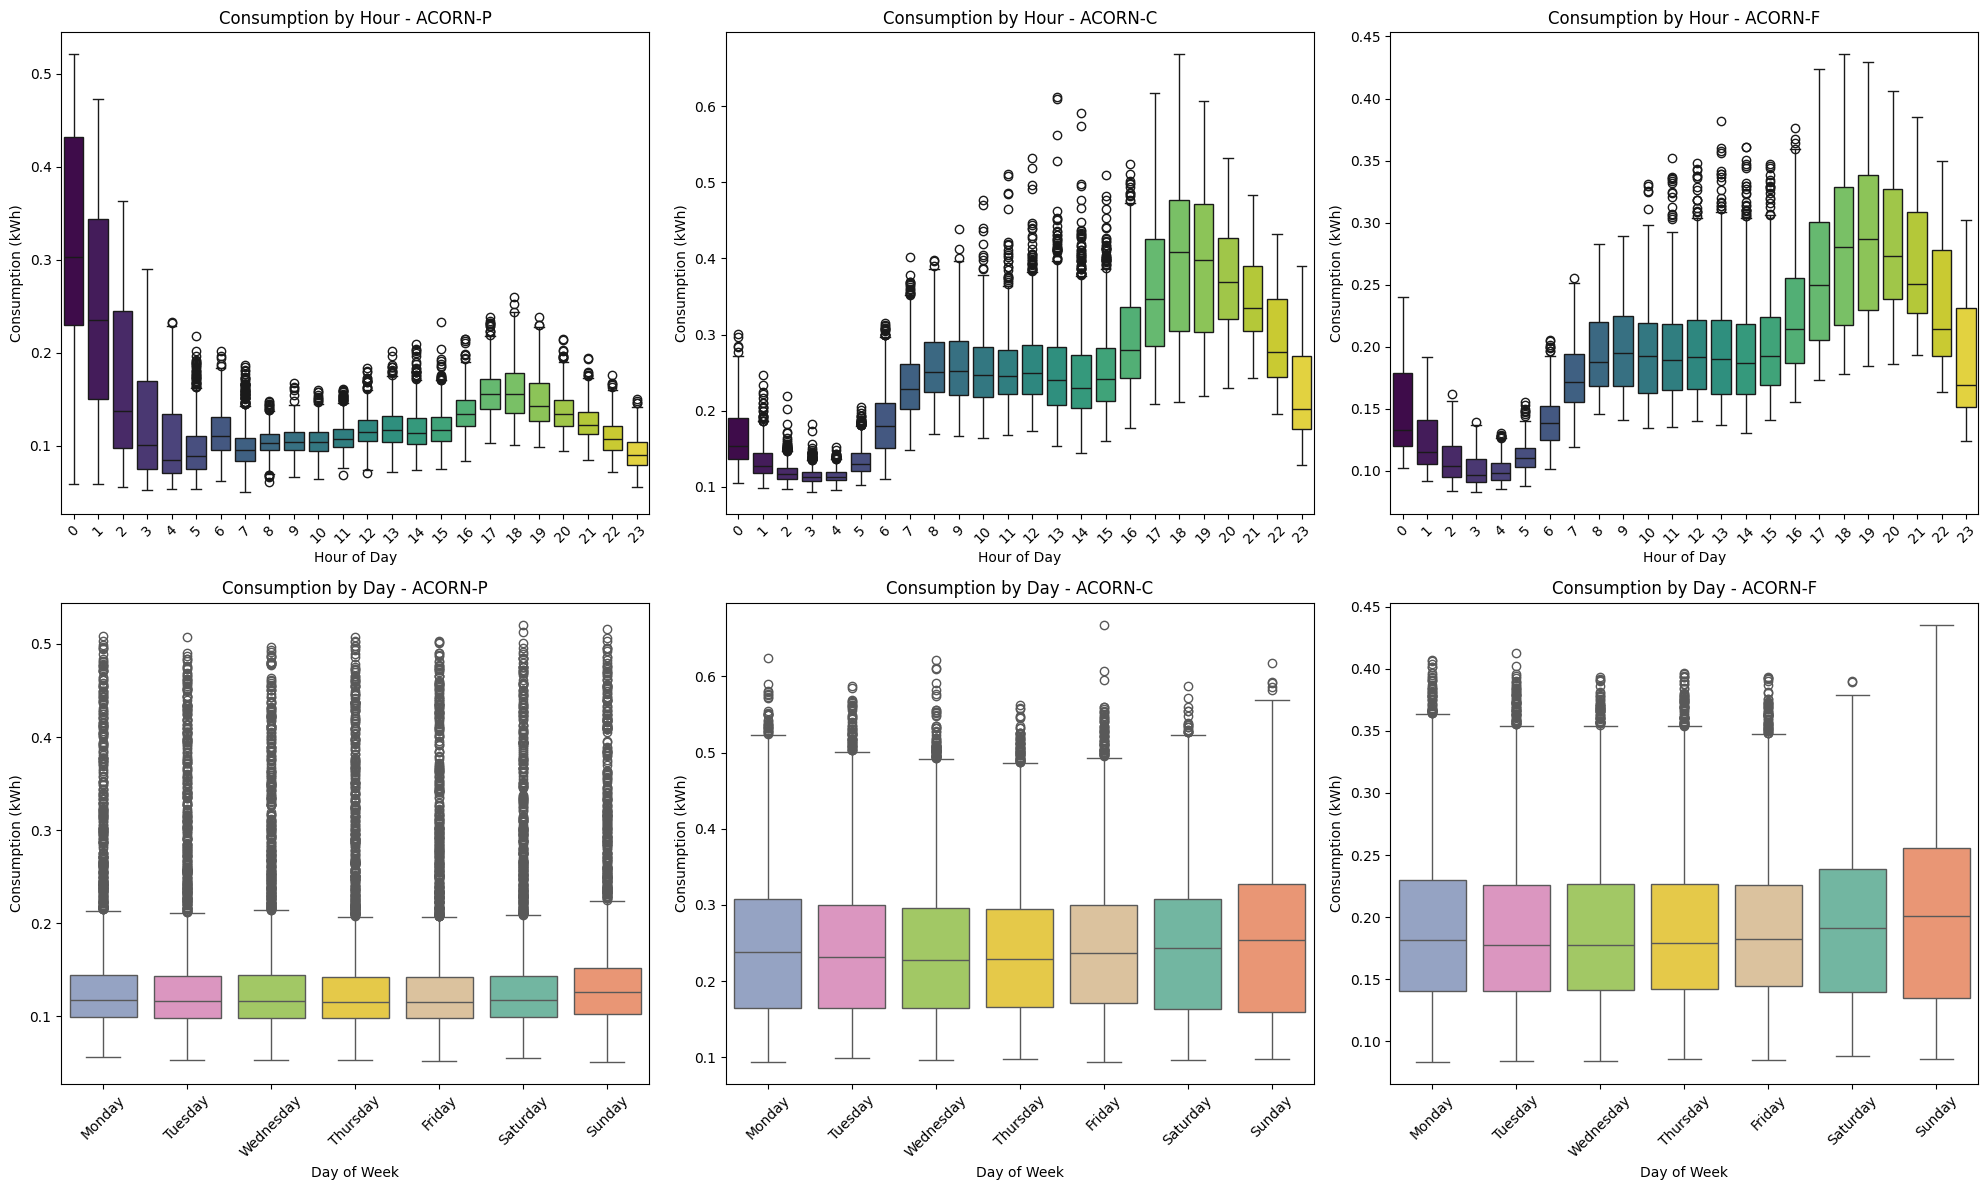

In [145]:
# Boxplots of hour of day/day of week consumption for each Acorn group
create_temporal_boxplots(group_4_half_hourly, acorn_groups, DAY_ORDER)

## Seasonality and Events

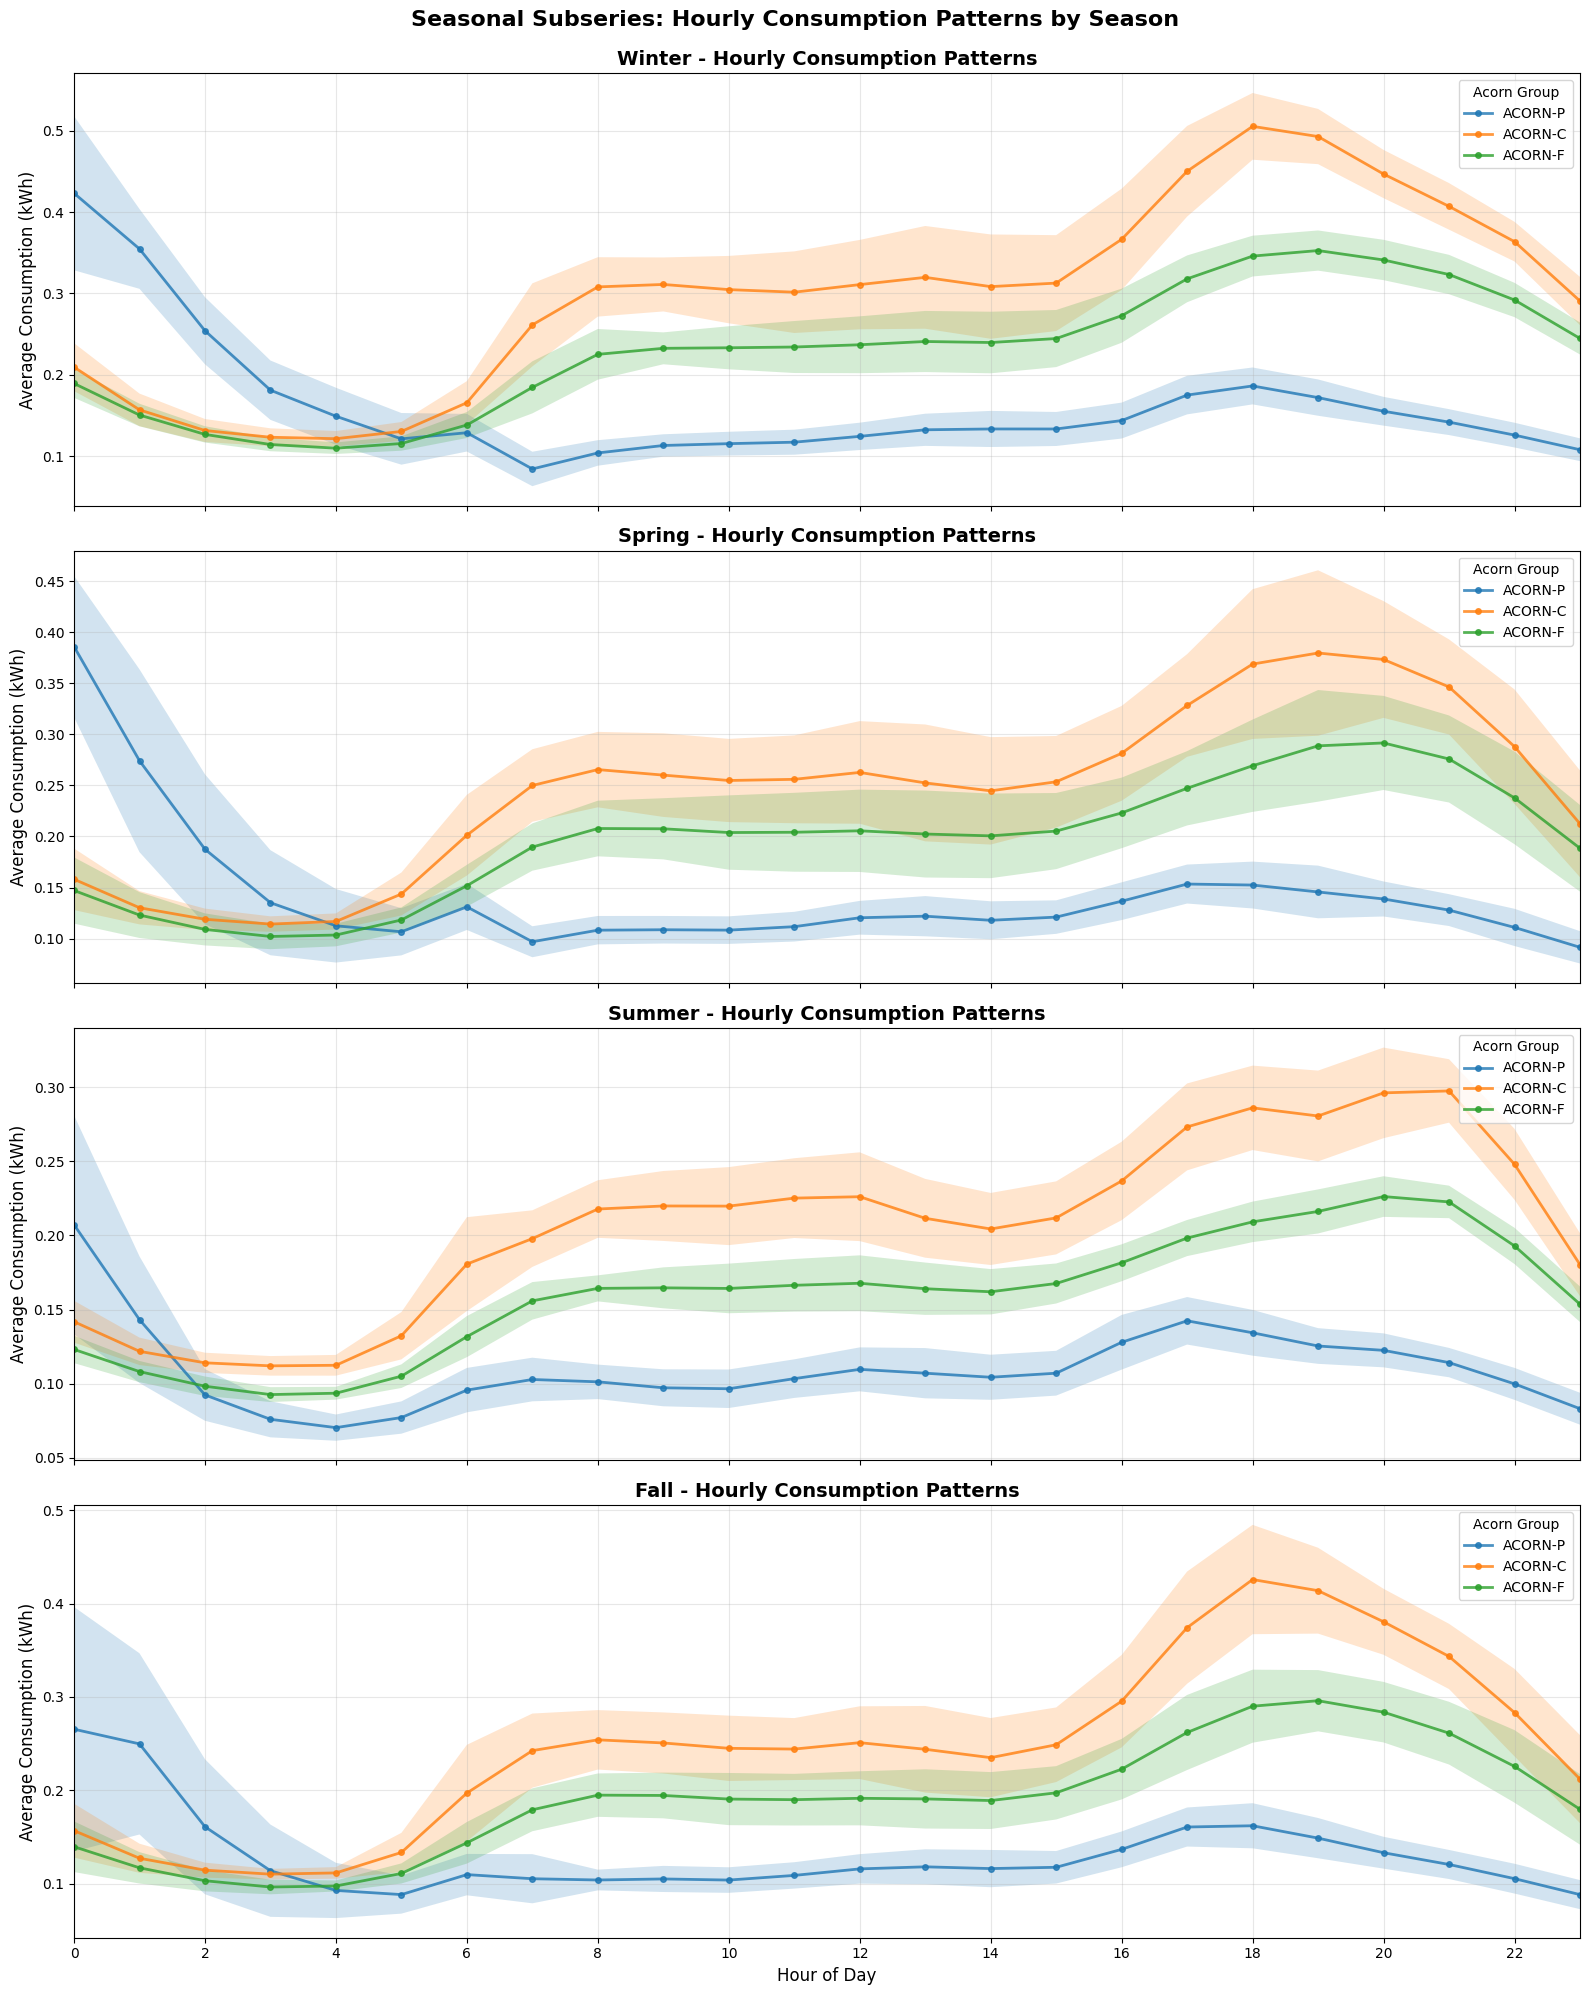


=== SEASONAL SUBSERIES ANALYSIS ===
Peak hours and consumption levels by season and Acorn group:

--- WINTER ---
ACORN-P: Peak at 00:00 (0.423 kWh), Min at 07:00 (0.085 kWh)
ACORN-C: Peak at 18:00 (0.505 kWh), Min at 04:00 (0.122 kWh)
ACORN-F: Peak at 19:00 (0.353 kWh), Min at 04:00 (0.110 kWh)

--- SPRING ---
ACORN-P: Peak at 00:00 (0.386 kWh), Min at 23:00 (0.091 kWh)
ACORN-C: Peak at 19:00 (0.380 kWh), Min at 03:00 (0.114 kWh)
ACORN-F: Peak at 20:00 (0.292 kWh), Min at 03:00 (0.102 kWh)

--- SUMMER ---
ACORN-P: Peak at 00:00 (0.207 kWh), Min at 04:00 (0.070 kWh)
ACORN-C: Peak at 21:00 (0.297 kWh), Min at 03:00 (0.112 kWh)
ACORN-F: Peak at 20:00 (0.226 kWh), Min at 03:00 (0.093 kWh)

--- FALL ---
ACORN-P: Peak at 00:00 (0.265 kWh), Min at 23:00 (0.088 kWh)
ACORN-C: Peak at 18:00 (0.426 kWh), Min at 03:00 (0.110 kWh)
ACORN-F: Peak at 19:00 (0.296 kWh), Min at 03:00 (0.096 kWh)


In [146]:
# Seasonal subseries plot - showing hourly patterns within each season

# Create seasonal analysis using utility function
create_seasonal_analysis(group_4_half_hourly, acorn_groups, SEASON_ORDER)

# Print seasonal summary using utility function
print_seasonal_summary(group_4_half_hourly, acorn_groups, SEASON_ORDER)

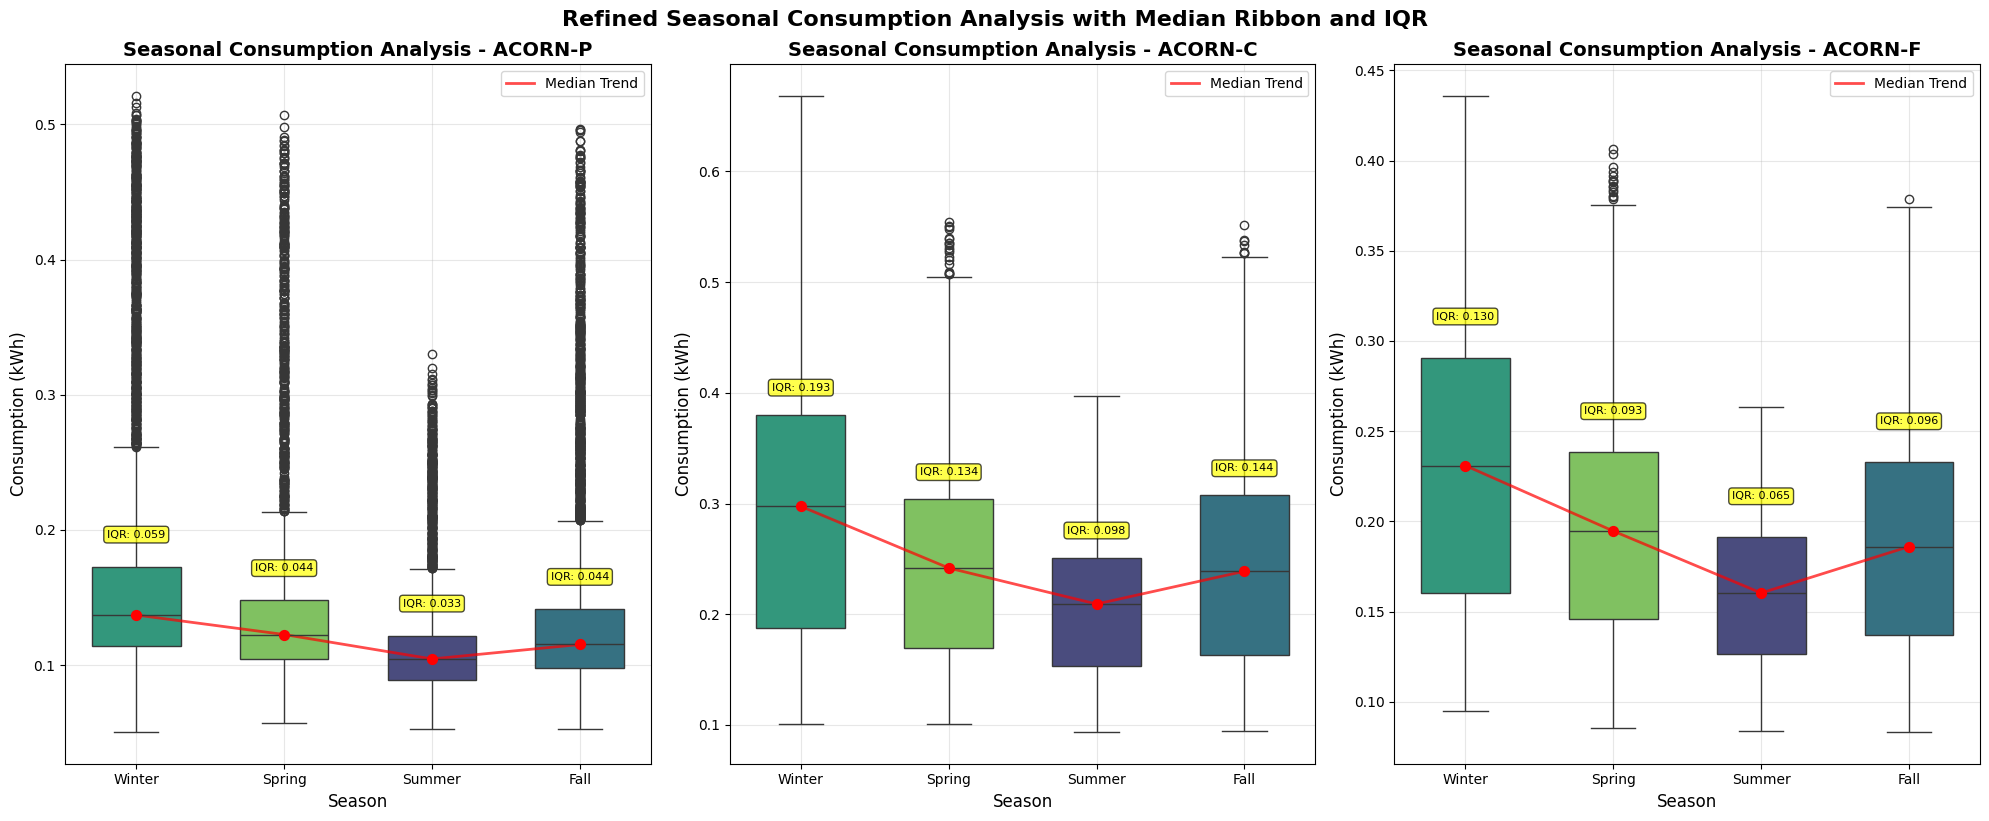


=== SEASONAL CONSUMPTION STATISTICS ===

Summary by Acorn Group and Season:

--- ACORN-P ---
        Count    Mean  Median     Std      Q1      Q3     IQR
Season                                                       
Fall     8736  0.1303  0.1153  0.0604  0.0978  0.1416  0.0438
Spring   4416  0.1419  0.1227  0.0713  0.1044  0.1481  0.0437
Summer   7396  0.1100  0.1046  0.0354  0.0887  0.1218  0.0331
Winter   6384  0.1617  0.1371  0.0831  0.1140  0.1728  0.0588

--- ACORN-C ---
        Count    Mean  Median     Std      Q1      Q3     IQR
Season                                                       
Fall     8736  0.2456  0.2389  0.0994  0.1631  0.3074  0.1443
Spring   4416  0.2442  0.2418  0.0924  0.1695  0.3039  0.1344
Summer   7396  0.2062  0.2092  0.0626  0.1533  0.2511  0.0978
Winter   6384  0.2959  0.2975  0.1209  0.1873  0.3802  0.1929

--- ACORN-F ---
        Count    Mean  Median     Std      Q1      Q3     IQR
Season                                                       
Fall

In [147]:
# Refined boxplots by season with median ribbon and interquartile range

# First, add season column to the data
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # months 9, 10, 11
        return 'Fall'

# Add season column
group_4_half_hourly['Season'] = group_4_half_hourly['DateTime'].dt.month.apply(get_season)

# Define season order for plotting
SEASON_ORDER = ['Winter', 'Spring', 'Summer', 'Fall']

# Create refined boxplots by season for each Acorn group
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, acorn_group in enumerate(acorn_groups):
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    
    # Create boxplot with enhanced styling
    box_plot = sns.boxplot(x='Season', y='Conso_moy', data=acorn_data, 
                          order=SEASON_ORDER, ax=axes[idx], 
                          hue='Season', palette='viridis', width=0.6, legend=False)
    
    # Calculate statistics for each season
    season_stats = []
    for season in SEASON_ORDER:
        season_data = acorn_data[acorn_data['Season'] == season]['Conso_moy']
        if len(season_data) > 0:
            q1 = season_data.quantile(0.25)
            q3 = season_data.quantile(0.75)
            median = season_data.median()
            season_stats.append({'season': season, 'q1': q1, 'q3': q3, 'median': median})
    
    # Add median ribbon (connecting medians)
    if len(season_stats) > 1:
        x_positions = range(len(SEASON_ORDER))
        medians = [stat['median'] for stat in season_stats]
        axes[idx].plot(x_positions, medians, 'r-', linewidth=2, alpha=0.7, label='Median Trend')
        axes[idx].scatter(x_positions, medians, color='red', s=50, zorder=5)
    
    # Add interquartile range ribbons
    for i, stat in enumerate(season_stats):
        # Add subtle fill between Q1 and Q3
        axes[idx].fill_between([i-0.3, i+0.3], [stat['q1'], stat['q1']], 
                              [stat['q3'], stat['q3']], alpha=0.2, color='lightblue')
    
    # Customize the plot
    axes[idx].set_title(f'Seasonal Consumption Analysis - {acorn_group}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Season', fontsize=12)
    axes[idx].set_ylabel('Consumption (kWh)', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    
    # Add statistical annotations
    for i, stat in enumerate(season_stats):
        # Add text with IQR information
        iqr = stat['q3'] - stat['q1']
        axes[idx].text(i, stat['q3'] + 0.02, f'IQR: {iqr:.3f}', 
                      ha='center', va='bottom', fontsize=8, 
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.suptitle('Refined Seasonal Consumption Analysis with Median Ribbon and IQR', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print summary statistics by season
print("\n=== SEASONAL CONSUMPTION STATISTICS ===")
print("\nSummary by Acorn Group and Season:")
for acorn_group in acorn_groups:
    print(f"\n--- {acorn_group} ---")
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    seasonal_summary = acorn_data.groupby('Season')['Conso_moy'].agg([
        'count', 'mean', 'median', 'std', 
        lambda x: x.quantile(0.25), 
        lambda x: x.quantile(0.75)
    ]).round(4)
    seasonal_summary.columns = ['Count', 'Mean', 'Median', 'Std', 'Q1', 'Q3']
    seasonal_summary['IQR'] = (seasonal_summary['Q3'] - seasonal_summary['Q1']).round(4)
    print(seasonal_summary)

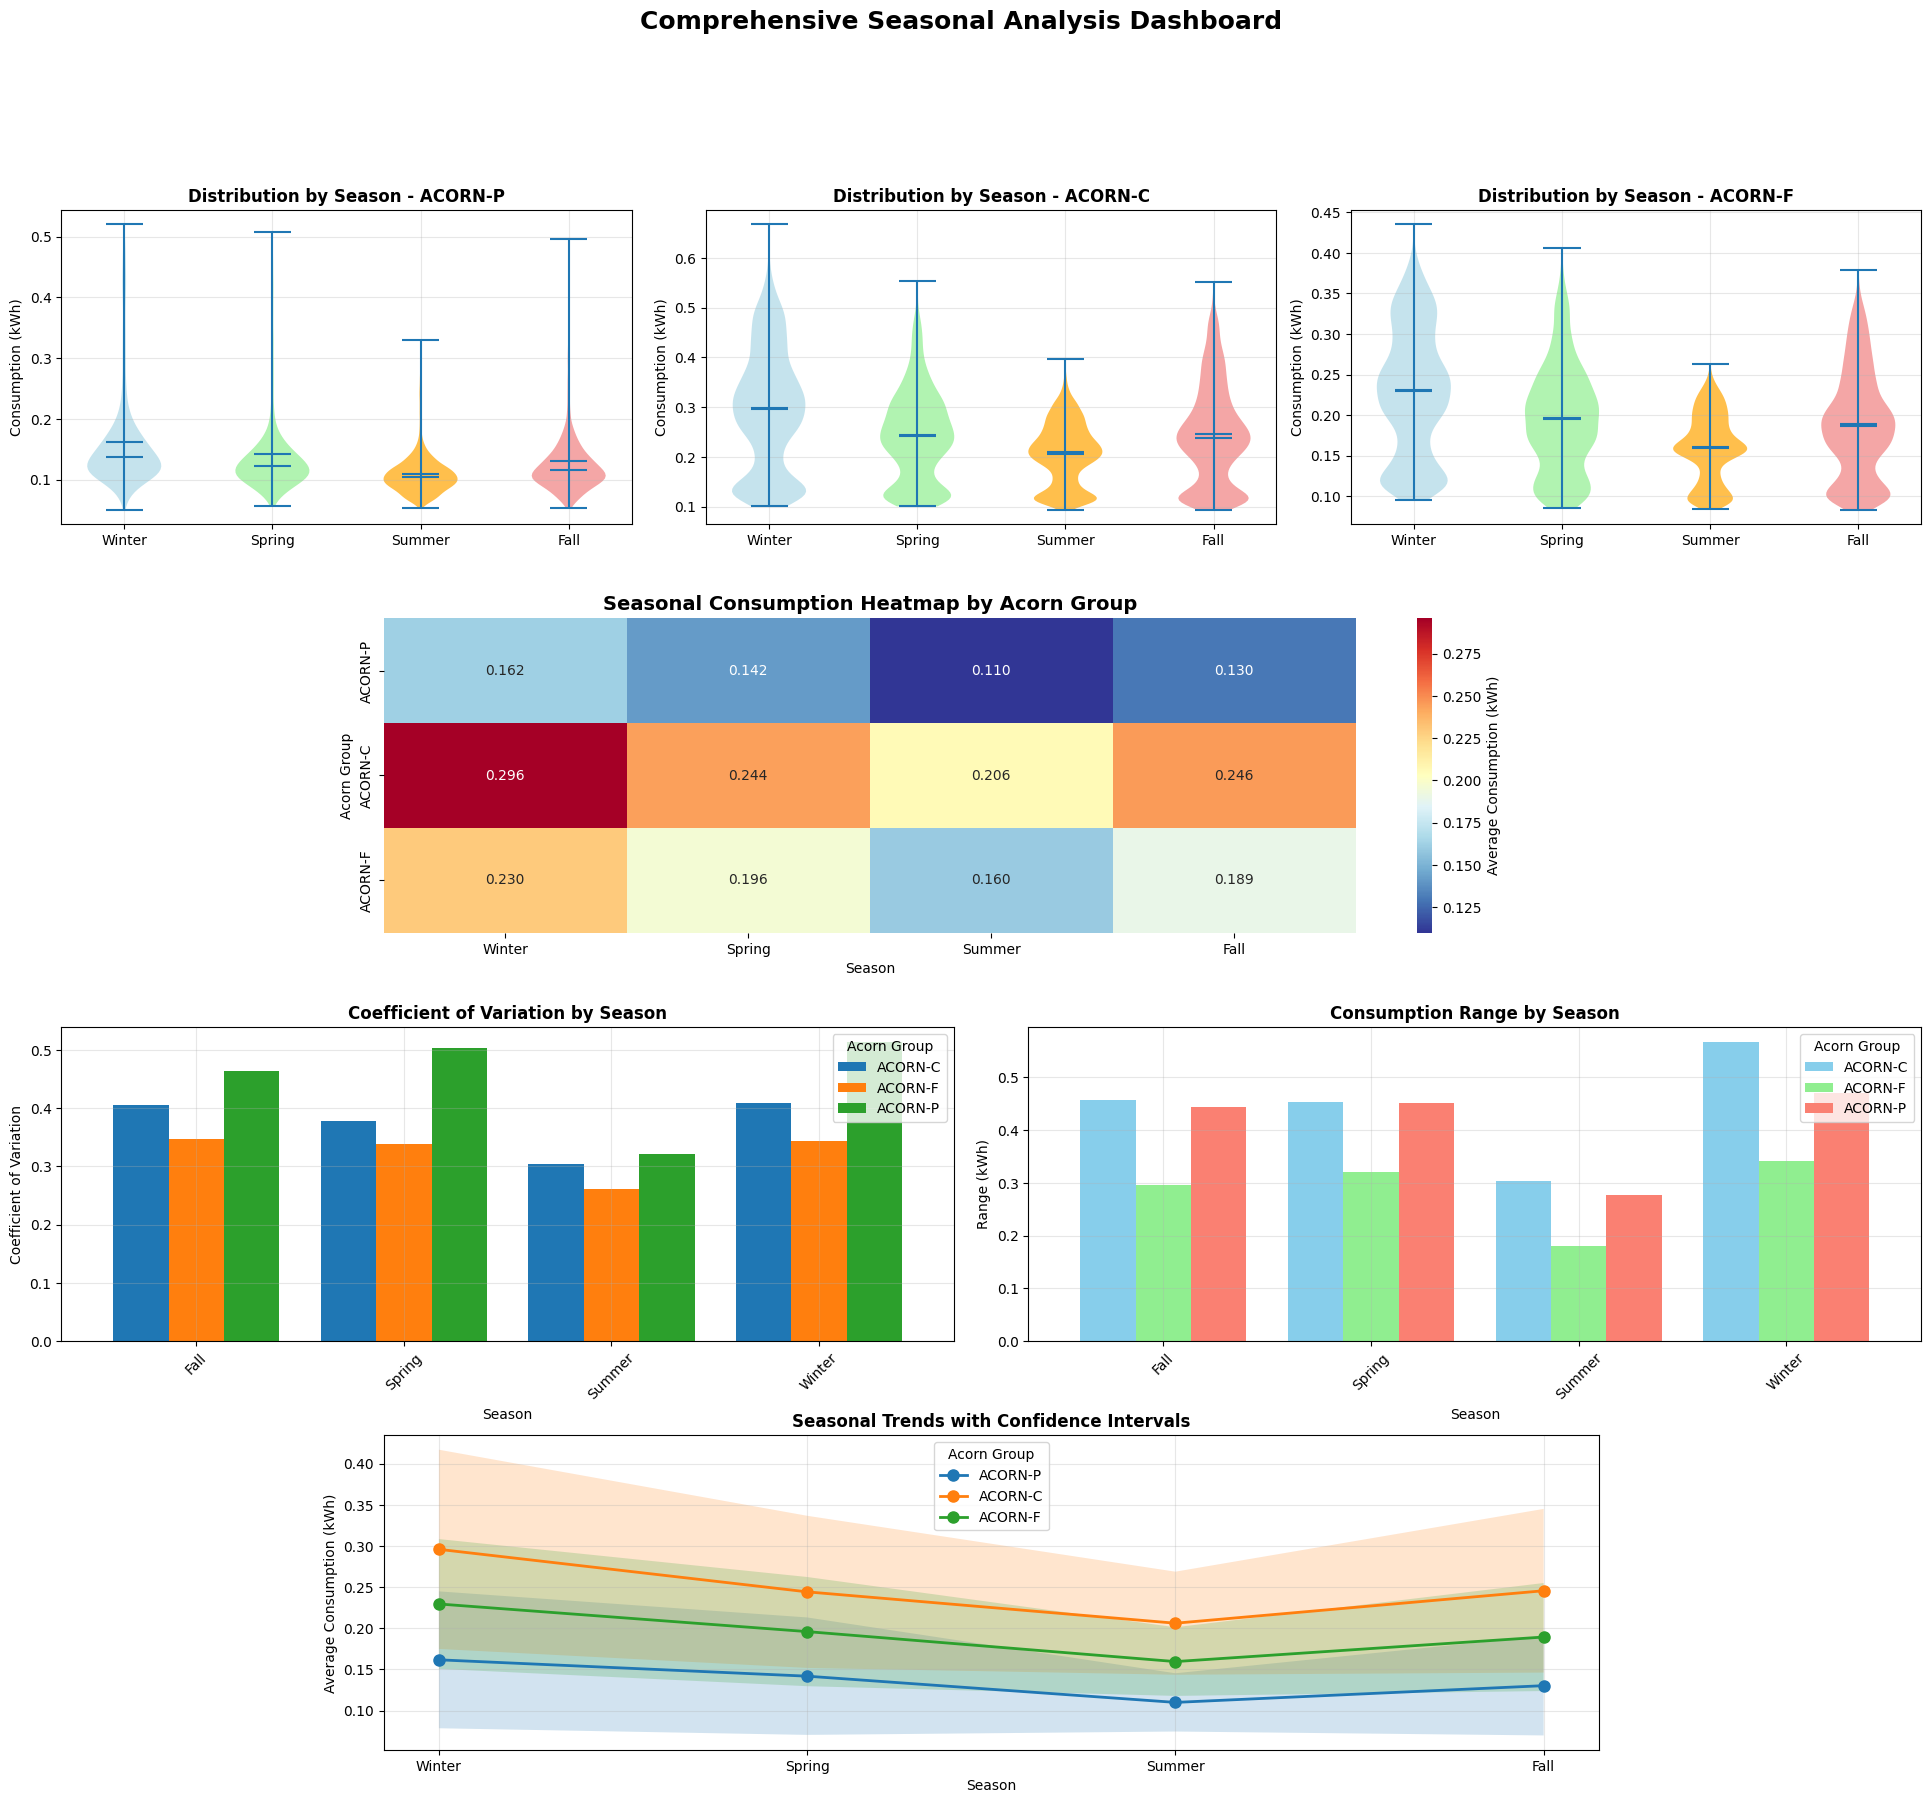


=== DETAILED SEASONAL ANALYSIS ===

Data period: 2012-06-30 22:00:00 to 2014-01-12 23:30:00
Total observations: 80,796

Seasonal distribution of observations:
Season
Fall      26208
Spring    13248
Summer    22188
Winter    19152
Name: count, dtype: int64

Seasonal variability analysis:

--- ACORN-P Seasonal Analysis ---
        Count    Mean  Median     Std     Min     Max      Q1      Q3     IQR  \
Season                                                                          
Fall     8736  0.1303  0.1153  0.0604  0.0527  0.4967  0.0978  0.1416  0.0438   
Spring   4416  0.1419  0.1227  0.0713  0.0570  0.5071  0.1044  0.1481  0.0437   
Summer   7396  0.1100  0.1046  0.0354  0.0531  0.3300  0.0887  0.1218  0.0331   
Winter   6384  0.1617  0.1371  0.0831  0.0506  0.5209  0.1140  0.1728  0.0588   

            CV   Range  
Season                  
Fall    0.4635  0.4440  
Spring  0.5025  0.4501  
Summer  0.3218  0.2769  
Winter  0.5139  0.4703  

--- ACORN-C Seasonal Analysis ---
    

In [148]:
# Advanced seasonal analysis with violin plots and distribution comparison

# Create a comprehensive seasonal analysis dashboard
fig = plt.figure(figsize=(24, 20))

# Create a grid layout - 4 rows, 6 columns for better centering
gs = fig.add_gridspec(4, 6, hspace=0.3, wspace=0.3)

# 1. Violin plots for each Acorn group (top row) - centered
for idx, acorn_group in enumerate(acorn_groups):
    # Distribute the 3 plots evenly in 6 columns: 0:2, 2:4, 4:6 (2 columns each)
    if idx == 0:
        ax = fig.add_subplot(gs[0, 0:2])
    elif idx == 1:
        ax = fig.add_subplot(gs[0, 2:4])
    else:  # idx == 2
        ax = fig.add_subplot(gs[0, 4:6])
    
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    
    # Create violin plot
    parts = ax.violinplot([acorn_data[acorn_data['Season'] == season]['Conso_moy'].values 
                          for season in SEASON_ORDER], 
                         positions=range(len(SEASON_ORDER)), 
                         showmeans=True, showmedians=True, showextrema=True)
    
    # Customize violin plot colors
    colors = ['lightblue', 'lightgreen', 'orange', 'lightcoral']
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    ax.set_xticks(range(len(SEASON_ORDER)))
    ax.set_xticklabels(SEASON_ORDER)
    ax.set_title(f'Distribution by Season - {acorn_group}', fontweight='bold')
    ax.set_ylabel('Consumption (kWh)')
    ax.grid(True, alpha=0.3)

# 2. Seasonal comparison heatmap (second row, spanning all columns) - centered
ax_heatmap = fig.add_subplot(gs[1, 1:5])  # Center the heatmap by using columns 1-4

# Create seasonal comparison matrix
seasonal_comparison = []
for acorn_group in acorn_groups:
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    row = []
    for season in SEASON_ORDER:
        mean_consumption = acorn_data[acorn_data['Season'] == season]['Conso_moy'].mean()
        row.append(mean_consumption)
    seasonal_comparison.append(row)

seasonal_df = pd.DataFrame(seasonal_comparison, 
                          index=acorn_groups, 
                          columns=SEASON_ORDER)

# Create heatmap
sns.heatmap(seasonal_df, annot=True, fmt='.3f', cmap='RdYlBu_r', 
           ax=ax_heatmap, cbar_kws={'label': 'Average Consumption (kWh)'})
ax_heatmap.set_title('Seasonal Consumption Heatmap by Acorn Group', 
                    fontsize=14, fontweight='bold')
ax_heatmap.set_xlabel('Season')
ax_heatmap.set_ylabel('Acorn Group')

# 3. Statistical comparison (third row)
# Coefficient of Variation by season
ax_cv = fig.add_subplot(gs[2, 0:3])  # Span first three columns
cv_data = []
for season in SEASON_ORDER:
    season_data = group_4_half_hourly[group_4_half_hourly['Season'] == season]
    for acorn_group in acorn_groups:
        acorn_season_data = season_data[season_data['Acorn'] == acorn_group]['Conso_moy']
        if len(acorn_season_data) > 0:
            cv = acorn_season_data.std() / acorn_season_data.mean()
            cv_data.append({'Season': season, 'Acorn': acorn_group, 'CV': cv})

cv_df = pd.DataFrame(cv_data)
cv_pivot = cv_df.pivot(index='Season', columns='Acorn', values='CV')
cv_pivot.plot(kind='bar', ax=ax_cv, width=0.8)
ax_cv.set_title('Coefficient of Variation by Season', fontweight='bold')
ax_cv.set_ylabel('Coefficient of Variation')
ax_cv.tick_params(axis='x', rotation=45)
ax_cv.legend(title='Acorn Group')
ax_cv.grid(True, alpha=0.3)

# Range analysis by season
ax_range = fig.add_subplot(gs[2, 3:6])  # Span last three columns
range_data = []
for season in SEASON_ORDER:
    season_data = group_4_half_hourly[group_4_half_hourly['Season'] == season]
    for acorn_group in acorn_groups:
        acorn_season_data = season_data[season_data['Acorn'] == acorn_group]['Conso_moy']
        if len(acorn_season_data) > 0:
            data_range = acorn_season_data.max() - acorn_season_data.min()
            range_data.append({'Season': season, 'Acorn': acorn_group, 'Range': data_range})

range_df = pd.DataFrame(range_data)
range_pivot = range_df.pivot(index='Season', columns='Acorn', values='Range')
range_pivot.plot(kind='bar', ax=ax_range, width=0.8, color=['skyblue', 'lightgreen', 'salmon'])
ax_range.set_title('Consumption Range by Season', fontweight='bold')
ax_range.set_ylabel('Range (kWh)')
ax_range.tick_params(axis='x', rotation=45)
ax_range.legend(title='Acorn Group')
ax_range.grid(True, alpha=0.3)

# 4. Seasonal trend analysis (fourth row, spanning all columns) - centered
ax_trend = fig.add_subplot(gs[3, 1:5])  # Center the trend plot by using columns 1-4
for acorn_group in acorn_groups:
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    seasonal_means = [acorn_data[acorn_data['Season'] == season]['Conso_moy'].mean() 
                     for season in SEASON_ORDER]
    ax_trend.plot(SEASON_ORDER, seasonal_means, marker='o', linewidth=2, 
                 markersize=8, label=acorn_group)
    
    # Add confidence intervals
    seasonal_stds = [acorn_data[acorn_data['Season'] == season]['Conso_moy'].std() 
                    for season in SEASON_ORDER]
    ax_trend.fill_between(SEASON_ORDER, 
                         [m - s for m, s in zip(seasonal_means, seasonal_stds)],
                         [m + s for m, s in zip(seasonal_means, seasonal_stds)],
                         alpha=0.2)

ax_trend.set_title('Seasonal Trends with Confidence Intervals', fontweight='bold')
ax_trend.set_ylabel('Average Consumption (kWh)')
ax_trend.set_xlabel('Season')
ax_trend.legend(title='Acorn Group')
ax_trend.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Seasonal Analysis Dashboard', 
             fontsize=18, fontweight='bold', y=0.98)
plt.show()

# Print detailed seasonal statistics
print("\n=== DETAILED SEASONAL ANALYSIS ===")
print(f"\nData period: {group_4_half_hourly['DateTime'].min()} to {group_4_half_hourly['DateTime'].max()}")
print(f"Total observations: {len(group_4_half_hourly):,}")

print("\nSeasonal distribution of observations:")
print(group_4_half_hourly['Season'].value_counts().sort_index())

print("\nSeasonal variability analysis:")
for acorn_group in acorn_groups:
    print(f"\n--- {acorn_group} Seasonal Analysis ---")
    acorn_data = group_4_half_hourly[group_4_half_hourly['Acorn'] == acorn_group]
    
    seasonal_stats = acorn_data.groupby('Season')['Conso_moy'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.75)
    ]).round(4)
    
    seasonal_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q1', 'Q3']
    seasonal_stats['IQR'] = (seasonal_stats['Q3'] - seasonal_stats['Q1']).round(4)
    seasonal_stats['CV'] = (seasonal_stats['Std'] / seasonal_stats['Mean']).round(4)
    seasonal_stats['Range'] = (seasonal_stats['Max'] - seasonal_stats['Min']).round(4)
    
    print(seasonal_stats)

## Holidays Analysis

In [149]:
# Comparing Holiday vs Weekend Daily Consumption

# First, let's examine the holiday data structure
print("=== UK BANK HOLIDAYS DATA OVERVIEW ===")
print(f"Holiday dataset shape: {uk_bank_holidays.shape}")
print(f"Date range: {uk_bank_holidays['Bank holidays'].min()} to {uk_bank_holidays['Bank holidays'].max()}")
print(f"\nSample holidays:")
print(uk_bank_holidays.head(10))
print(f"\nUnique holiday types:")
print(uk_bank_holidays['Type'].value_counts())

# Check the daily data structure
print(f"\n=== DAILY DATA STRUCTURE ===")
print(f"Daily data columns: {list(group_4_daily.columns)}")
print(f"Daily data shape: {group_4_daily.shape}")
print(f"Daily data sample:")
print(group_4_daily.head())

# Create a comprehensive holiday analysis
def create_holiday_dataset():
    """Create a dataset that merges daily consumption with holiday information"""
    
    # Use daily data for holiday analysis (more appropriate for daily patterns)
    daily_data = group_4_daily.copy()
    
    # Check if DateTime column exists, otherwise use the first datetime-like column
    datetime_col = None
    for col in daily_data.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            datetime_col = col
            break
    
    if datetime_col is None:
        datetime_col = daily_data.columns[0]  # Use first column as fallback
    
    print(f"Using datetime column: {datetime_col}")
    
    # Convert datetime column to date for matching
    daily_data['Date'] = pd.to_datetime(daily_data[datetime_col]).dt.date
    
    # Convert holiday dates to date format for matching
    holiday_dates = set(pd.to_datetime(uk_bank_holidays['Bank holidays']).dt.date)
    
    # Add holiday indicator
    daily_data['Is_Holiday'] = daily_data['Date'].isin(holiday_dates)
    
    # Add day of week information
    daily_data['DayOfWeek'] = pd.to_datetime(daily_data[datetime_col]).dt.day_name()
    daily_data['Is_Weekend'] = pd.to_datetime(daily_data[datetime_col]).dt.dayofweek.isin([5, 6])  # Saturday = 5, Sunday = 6
    
    # Create categories for analysis
    def get_day_category(row):
        if row['Is_Holiday']:
            return 'Holiday'
        elif row['Is_Weekend']:
            return 'Weekend'
        else:
            return 'Weekday'
    
    daily_data['Day_Category'] = daily_data.apply(get_day_category, axis=1)
    
    return daily_data, datetime_col

# Create the holiday dataset
holiday_data, datetime_column = create_holiday_dataset()

# Display basic statistics
print(f"\n=== DAILY CONSUMPTION HOLIDAY ANALYSIS ===")
print(f"Total daily observations: {len(holiday_data):,}")
print(f"\nDay category distribution:")
print(holiday_data['Day_Category'].value_counts())

print(f"\nHoliday dates in our dataset:")
holiday_days = holiday_data[holiday_data['Is_Holiday']]
if len(holiday_days) > 0:
    holiday_summary = holiday_days[['Date', 'DayOfWeek']].drop_duplicates().sort_values('Date')
    for _, row in holiday_summary.iterrows():
        print(f"  {row['Date']} ({row['DayOfWeek']})")
else:
    print("  No holidays found in the dataset period")

# Get unique Acorn groups
acorn_groups = holiday_data['Acorn'].unique()
print(f"\nAcorn groups: {list(acorn_groups)}")

# Check consumption column
consumption_col = None
for col in holiday_data.columns:
    if 'conso' in col.lower() or 'consumption' in col.lower():
        consumption_col = col
        break

if consumption_col is None:
    # Look for numeric columns that might be consumption
    numeric_cols = holiday_data.select_dtypes(include=[np.number]).columns
    consumption_col = numeric_cols[0] if len(numeric_cols) > 0 else 'Conso_moy'

print(f"Using consumption column: {consumption_col}")

# Update column reference for subsequent analysis
if consumption_col != 'Conso_moy':
    holiday_data['Conso_moy'] = holiday_data[consumption_col]



=== UK BANK HOLIDAYS DATA OVERVIEW ===
Holiday dataset shape: (25, 2)
Date range: 2012-02-01 00:00:00 to 2014-12-26 00:00:00

Sample holidays:
  Bank holidays                                          Type
0    2012-12-26                                    Boxing Day
1    2012-12-25                                 Christmas Day
2    2012-08-27                           Summer bank holiday
3    2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)
4    2012-04-06          Spring bank holiday (substitute day)
5    2012-07-05                        Early May bank holiday
6    2012-09-04                                 Easter Monday
7    2012-06-04                                   Good Friday
8    2012-02-01               New Year?s Day (substitute day)
9    2013-12-26                                    Boxing Day

Unique holiday types:
Type
Boxing Day                                      3
Christmas Day                                   3
Summer bank holiday                            

In [150]:
# Statistical comparison between Holidays and Weekends/Weekdays

# Perform statistical analysis
stats_results_df = perform_holiday_statistical_analysis(holiday_data, acorn_groups, 'Conso_kWh')

print("\n=== STATISTICAL COMPARISON ===")

for comparison_type in ['Holiday vs Weekend', 'Holiday vs Weekday']:
    print(f"\n--- {comparison_type.upper()} ---")
    comparison_data = stats_results_df[stats_results_df['Comparison'] == comparison_type]
    
    if comparison_data.empty:
        print(f"No data for {comparison_type} comparison.")
        continue

    for _, row in comparison_data.iterrows():
        print(f"\n----- {row['Acorn_Group']} -----")
        print(f"Holiday consumption:      {row['Group1_Mean']:.4f} ± {row['Group1_Std']:.4f} kWh (n={int(row['Group1_Count'])})")
        print(f"{comparison_type.split(' vs ')[1]} consumption: {row['Group2_Mean']:.4f} ± {row['Group2_Std']:.4f} kWh (n={int(row['Group2_Count'])})")
        print(f"Mean difference:          {row['Mean_Difference']:.4f} kWh")
        print(f"Effect size (Cohen's d):   {row['Cohens_D']:.4f}")
        print(f"Statistical significance: {'Yes' if row['Significant'] else 'No'} (p = {row['P_Value']:.4f})")
        
        # Interpret effect size
        if abs(row['Cohens_D']) < 0.2:
            effect_interpretation = "negligible"
        elif abs(row['Cohens_D']) < 0.5:
            effect_interpretation = "small"
        elif abs(row['Cohens_D']) < 0.8:
            effect_interpretation = "medium"
        else:
            effect_interpretation = "large"
        
        print(f"Effect size interpretation: {effect_interpretation}")
        
        if row['Mean_Difference'] > 0:
            print(f"Holidays have HIGHER consumption than {comparison_type.split(' vs ')[1].lower()}s")
        elif row['Mean_Difference'] < 0:
            print(f"Holidays have LOWER consumption than {comparison_type.split(' vs ')[1].lower()}s")
        else:
            print(f"Holidays have SIMILAR consumption to {comparison_type.split(' vs ')[1].lower()}s")


=== STATISTICAL COMPARISON ===

--- HOLIDAY VS WEEKEND ---

----- ACORN-C -----
Holiday consumption:      13.0602 ± 3.0459 kWh (n=14)
Weekend consumption: 12.1737 ± 1.8960 kWh (n=161)
Mean difference:          0.8865 kWh
Effect size (Cohen's d):   0.4420
Statistical significance: No (p = 0.1145)
Effect size interpretation: small
Holidays have HIGHER consumption than weekends

----- ACORN-F -----
Holiday consumption:      9.4934 ± 1.6568 kWh (n=14)
Weekend consumption: 9.5799 ± 1.5781 kWh (n=161)
Mean difference:          -0.0864 kWh
Effect size (Cohen's d):   -0.0546
Statistical significance: No (p = 0.8450)
Effect size interpretation: negligible
Holidays have LOWER consumption than weekends

----- ACORN-P -----
Holiday consumption:      6.5346 ± 1.0020 kWh (n=14)
Weekend consumption: 6.5465 ± 1.1862 kWh (n=161)
Mean difference:          -0.0119 kWh
Effect size (Cohen's d):   -0.0102
Statistical significance: No (p = 0.9709)
Effect size interpretation: negligible
Holidays have LOWER c

### Holiday Electricity Consumption Analysis  
### 1 · Group-by-Group Findings

| Comparison | ACORN-C | ACORN-F | ACORN-P |
|------------|---------|---------|---------|
| **Holiday vs Weekend** | **+0.89 kWh**<br>_small effect_ (d = 0.44); _not sig._ (p = 0.11) | –0.09 kWh<br>_negligible_ (d = –0.05); _not sig._ | –0.01 kWh<br>_negligible_ (d = –0.01); _not sig._ |
| **Holiday vs Weekday** | **+1.42 kWh**<br>_medium effect_ (d = 0.79); **significant** (p = 0.004) | +0.45 kWh<br>_small effect_ (d = 0.32); _not sig._ | +0.15 kWh<br>_negligible_ (d = 0.13); _not sig._ |

<sub>All significance tests are two-tailed; d = Cohen’s d.</sub>

---

### 2 · Interpretation

1. **ACORN-C (higher-consumption households)**  
   * Holidays show **meaningfully higher** usage than both weekends (+7 %) and weekdays (+12 %).  
   * Only the holiday-vs-weekday jump is statistically reliable (medium-sized, p < 0.01).  
   * Implication: special-occasion behaviour in this segment translates into real extra load.

2. **ACORN-F (mid-consumption households)**  
   * Holidays look virtually identical to weekends (–0.9 %).  
   * They run **about 5 % above weekdays**, but the effect is small and not significant.  
   * Behaviour suggests a mild “leisure-day” boost that is lost in statistical noise.

3. **ACORN-P (lower-consumption households)**  
   * Differences are practically zero versus both weekends and weekdays.  
   * Consumption patterns appear stable regardless of day type.

---

### 3 · Cross-Group Patterns

| Key Question | Short Answer |
|--------------|--------------|
| **Do holidays always beat weekends?** | Only for ACORN-C. Groups F and P actually dip (slightly) on holidays. |
| **Do holidays beat weekdays?** | Yes in every group, but the jump is **material and statistically solid only for ACORN-C**. |
| **Where is the practical impact?** | Aggregate load forecasting should flag holiday demand spikes mainly in areas with many ACORN-C customers. |

---

### 4 · Practical Takeaways

* **Targeted interventions** (e.g., holiday energy-saving campaigns) should focus on ACORN-C households; the other groups won’t yield big returns.  
* **System-level forecasting** should add a holiday premium chiefly when the network has a high share of ACORN-C customers.  
* **Statistical nuance:** absence of significance in F and P means observed differences could be pure sampling noise—avoid over-interpreting tiny kWh shifts.  